# **Project - Helsinki, Finland**
## Price of living in Helsinki, Finland – Neighborhood characteristics or geographical location?

# 1 Introduction/Business Problem

The price of living in Helsinki, the capital of Finland, is steadily increasing both for renting and buying apartments. At a population of approximately 650 000 people (1 200 000 if counting the neighboring cities of Espoo and Vantaa), Helsinki is the largest city in the country and is steadily growing in population. While many people move from other areas of Finland to the capital to work, the apartment prices may sometimes be double of what they paid for a similarly sized apartment back home. Prices in Helsinki, however, may vary depending on location and neighborhood. 

This research will explore if there are differences between the price and location depending on the characteristics of the neighborhood, or if the price of living is solely tied to the geographic location of the neighborhood. The research is aimed towards giving insight of the differences in prices for those moving or planning to move to Helsinki.


# 2 Data and analysis

The data that will be used in the research are location data of each neighborhood, such as coordinates, name, and postal code. Other neighborhood specific data include average price per square meter. Finding the characteristics of the neighborhood requires more specific data of the areas, such as information about venues in the neighborhood. 

In [1]:
#imports

import pandas as pd # library for data analsysis
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

import numpy as np # library to handle data in a vectorized manner

from decouple import config # for importing API info 

import requests # library to handle requests

# Matplotlib and associated plotting modules
import matplotlib.pyplot as plt 
import matplotlib.cm as cm
import matplotlib.colors as colors

# libraries for statistical purposes
from sklearn.cluster import KMeans # import k-means from clustering stage
from scipy.spatial.distance import cdist # importing for cdist
from sklearn.metrics import silhouette_score # for calculating silhoutte score of k-mean model

import folium # import folium, map rendering library

from bs4 import BeautifulSoup # import BeautifulSoup for webscraping

import geocoder # import geocoder for coordinates
from  geopy.geocoders import Nominatim # Nominatim for querying coordinates

# libraries for reading in and editing geographical areas
from owslib.wfs import WebFeatureService
from pandas.io.json import json_normalize
import geopandas as gpd
from osgeo import gdal, ogr

# for changing coordinate system
import pyproj
from pyproj import CRS

# 3 Webscraping and obtaining initial data

Lets begin by getting neighborhood specific data

**Extracting housing price data of districs in Finland**

In [2]:
website_url = requests.get('https://blok.ai/en/neighbourhoods/')
soup = BeautifulSoup(website_url.content,'html.parser')
# print(soup_data.prettify()) # uncomment to see raw html data

**Saving relevant headers for our research (Postcode, Neighborhood, Average price per square 2020). City column is also extracted for further cleaning purposes**

In [3]:
headers = [c.get_text() for c in soup.find('thead').find_all('th')[2:6]]
headers

['Postcode', 'Neighborhood', 'City', 'Average price per square 2020']

### **Extracting relevant data and saving it into a dataframe using headers as columns**

In [4]:
table = soup.find('tbody').find_all('tr')
table_contents = [[cell.get_text(strip=True) for cell in row.find_all('td')[2:6]]
        for row in table]

df=pd.DataFrame(table_contents, columns=headers)

**Displaying first five entries**

In [5]:
df.head()

,Postcode,Neighborhood,City,Average price per square 2020
0,00140,Kaivopuisto - Ullanlinna,Helsinki,8713
1,00150,Eira - Hernesaari,Helsinki,8367
2,00120,Punavuori,Helsinki,8160
3,00180,Kamppi - Ruoholahti,Helsinki,8023
4,00220,Jätkäsaari,Helsinki,7871


**Displaying shape**

In [6]:
df.shape

(846, 4)

## Cleaning data

**Since dataframe contains all districs in Finland and we only want districs located in Helsinki, we will remove other data entries and city column.**

In [7]:
helsinki_data = df.loc[df['City'] == 'Helsinki']
helsinki_data.drop(columns=['City'], axis = 1, inplace = True)
helsinki_data.reset_index(drop=True, inplace=True)


C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\frame.py:4163: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


**Check first five entries**

helsinki_data.head()

**Shape of new dataframe**

In [8]:
helsinki_data.shape

(78, 3)

**Adding coordinates**

In [9]:
column_names = ['Postcode', 'Neighborhood', 'Average price', 'Latitude', 'Longitude'] 
neighborhoods = pd.DataFrame(columns=column_names)


# iterating through helsinki df (This may take a minute)
for i in range(len(helsinki_data)):

    postalCode = helsinki_data.iloc[i]['Postcode']
    neighborhood_name = helsinki_data.iloc[i]['Neighborhood']
    price = helsinki_data.iloc[i]['Average price per square 2020'] 

    # getting coordinates for each neighborhood
    geolocator = Nominatim(user_agent=config('USER_AGENT'))
    loc = geolocator.geocode('{}, Helsinki, Finland'.format(postalCode))
    latitude = loc.latitude
    longitude = loc.longitude

    # appending data to new df
    neighborhoods = neighborhoods.append({'Postcode': postalCode,
                                          'Neighborhood': neighborhood_name,
                                          'Average price': price,
                                          'Latitude': latitude,
                                          'Longitude': longitude}, ignore_index=True)


**Manually Correcting some of the coordinates that were completely wrong**

In [10]:
neighborhoods.at[neighborhoods.index[neighborhoods['Neighborhood'] == 'Herttoniemi'], ['Latitude', 'Longitude']] = 60.195415, 25.033302
neighborhoods.at[neighborhoods.index[neighborhoods['Neighborhood'] == 'Itä-Pasila'], ['Latitude', 'Longitude']] = 60.200041, 24.939573
neighborhoods.at[neighborhoods.index[neighborhoods['Neighborhood'] == 'Veräjämäki'], ['Latitude', 'Longitude']] = 60.227290, 24.972098
neighborhoods.at[neighborhoods.index[neighborhoods['Neighborhood'] == 'Puistola'], ['Latitude', 'Longitude']] = 60.271337, 25.045611
neighborhoods.at[neighborhoods.index[neighborhoods['Neighborhood'] == 'Suurmetsä'], ['Latitude', 'Longitude']] = 60.265790, 25.079472
neighborhoods.at[neighborhoods.index[neighborhoods['Neighborhood'] == 'Maununneva'], ['Latitude', 'Longitude']] = 60.244833, 24.898528
neighborhoods.at[neighborhoods.index[neighborhoods['Neighborhood'] == 'Kivihaka'], ['Latitude', 'Longitude']] = 60.210680, 24.903876
                                       

**Check first five entries on new dataframe**

In [11]:
neighborhoods.head()

,Postcode,Neighborhood,Average price,Latitude,Longitude
0,00140,Kaivopuisto - Ullanlinna,8713,60.157935,24.952702
1,00150,Eira - Hernesaari,8367,60.158939,24.938014
2,00120,Punavuori,8160,60.163562,24.939202
3,00180,Kamppi - Ruoholahti,8023,60.163576,24.917557
4,00220,Jätkäsaari,7871,60.157433,24.917381


**Check shape to see if still consistent**

In [12]:
neighborhoods.shape

(78, 5)

**Plot the neighborhoods to check that coordinates are correct**

In [13]:
# creating a map of helsinki using latitude and longitude values
helsinki_map = folium.Map(location=[latitude, longitude], zoom_start=11)

# adding markers to map
for lat, lng, label in zip(neighborhoods['Latitude'], neighborhoods['Longitude'], neighborhoods['Neighborhood']):
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(helsinki_map)  
    
helsinki_map

# 4 Fetching Foursquare data for venues

Okay, now that we have the neighborhood data, we will start fetching venue specific data for each neighborhood using Foursquare API

**Paramater preparation**

In [14]:
CLIENT_ID = config('API_ID') # Foursquare ID
CLIENT_SECRET = config('API_SECRET') # Foursquare Secret
VERSION = '20180605' # Foursquare API version
LIMIT = 100 # default Foursquare API limit value
radius = 500 # radius in meter

**Function for getting venues**

In [15]:
def getNearbyVenues(names, latitudes, longitudes, radius):
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT) 
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']  
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])
    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    return(nearby_venues)

**Function for saving results**

In [16]:
helsinki_venues = getNearbyVenues(names=neighborhoods['Neighborhood'],
                                   latitudes=neighborhoods['Latitude'],
                                   longitudes=neighborhoods['Longitude'],
                                   radius=radius
                                  )

In [17]:
# saving df in case of hitting limit cap on Foursquare API
helsinki_venues.to_csv('helsinki_venues.csv', index=False)

**Checking first five entries in dataframe**

In [18]:
helsinki_venues.head()

,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Kaivopuisto - Ullanlinna,60.157935,24.952702,Kaivopuisto / Brunnsparken (Kaivopuisto),60.156810,24.956732,Park
1,Kaivopuisto - Ullanlinna,60.157935,24.952702,Rams Roasters,60.158002,24.948908,Coffee Roaster
2,Kaivopuisto - Ullanlinna,60.157935,24.952702,Helsingin Jäätelötehdas,60.155643,24.950891,Ice Cream Shop
3,Kaivopuisto - Ullanlinna,60.157935,24.952702,Paulette,60.158475,24.946111,French Restaurant
4,Kaivopuisto - Ullanlinna,60.157935,24.952702,Cafe Compass,60.155131,24.951614,Coffee Shop


Checking shape

In [19]:
helsinki_venues.shape

(1837, 7)

One hod encoding for dummies

In [20]:
helsinki_onehot = pd.get_dummies(helsinki_venues[['Venue Category']], prefix="", prefix_sep="")

# adding a neighborhood column to the dataframe
helsinki_onehot['Neighborhood'] = helsinki_venues['Neighborhood'] 

# moving neighborhood column to the first column
cols = list(helsinki_onehot)
cols.insert(0, cols.pop(cols.index('Neighborhood')))
helsinki_onehot = helsinki_onehot.loc[:, cols]


In [21]:
# checking first 5 entries
helsinki_onehot.head()

,Neighborhood,ATM,Accessories Store,American Restaurant,Antique Shop,Art Gallery,Art Museum,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,Auditorium,Auto Dealership,Auto Garage,Auto Workshop,Automotive Shop,BBQ Joint,Badminton Court,Bagel Shop,Bakery,Bar,Baseball Field,Basketball Court,Bay,Beach,Beach Bar,Beer Bar,Beer Garden,Bike Shop,Bike Trail,Bistro,Boat or Ferry,Bookstore,Border Crossing,Boutique,Bowling Alley,Boxing Gym,Brazilian Restaurant,Breakfast Spot,Brewery,Bridge,Buffet,Burger Joint,Burrito Place,Bus Stop,Butcher,Cafeteria,Café,Canal,Candy Store,Caucasian Restaurant,Cheese Shop,Chinese Restaurant,Circus School,Climbing Gym,Clothing Store,Cocktail Bar,Coffee Roaster,Coffee Shop,College Cafeteria,College Science Building,Comedy Club,Comic Shop,Concert Hall,Construction & Landscaping,Convenience Store,Cosmetics Shop,Costume Shop,Creperie,Cruise Ship,Cultural Center,Cupcake Shop,Curling Ice,Dance Studio,Deli / Bodega,Department Store,Dessert Shop,Diner,Disc Golf,Discount Store,Distillery,Dive Bar,Dog Run,Doner Restaurant,Electronics Store,Escape Room,Ethiopian Restaurant,Event Space,Falafel Restaurant,Farmers Market,Fast Food Restaurant,Filipino Restaurant,Film Studio,Fish & Chips Shop,Fish Market,Flea Market,Flower Shop,Food,Food & Drink Shop,Food Court,Food Truck,Football Stadium,Forest,Fountain,French Restaurant,Furniture / Home Store,Garden,Garden Center,Gastropub,Gay Bar,German Restaurant,Gift Shop,Gourmet Shop,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Gym Pool,Harbor / Marina,Hardware Store,Hawaiian Restaurant,Health & Beauty Service,Health Food Store,High School,Hill,Himalayan Restaurant,Historic Site,History Museum,Hobby Shop,Hockey Arena,Hockey Rink,Home Service,Hostel,Hotel,Hotel Bar,IT Services,Ice Cream Shop,Indian Restaurant,Indie Movie Theater,Indie Theater,Indonesian Restaurant,Indoor Play Area,Intersection,Irish Pub,Italian Restaurant,Japanese Restaurant,Jazz Club,Jewelry Store,Karaoke Bar,Kebab Restaurant,Kids Store,Kitchen Supply Store,Knitting Store,Korean Restaurant,Kurdish Restaurant,Lake,Library,Liquor Store,Lounge,Malay Restaurant,Martial Arts School,Massage Studio,Mediterranean Restaurant,Men's Store,Metro Station,Mexican Restaurant,Middle Eastern Restaurant,Mini Golf,Miscellaneous Shop,Mobile Phone Shop,Modern European Restaurant,Molecular Gastronomy Restaurant,Monument / Landmark,Motorcycle Shop,Movie Theater,Multiplex,Museum,Music School,Music Store,Music Venue,Nightclub,Noodle House,Office,Opera House,Optical Shop,Organic Grocery,Other Great Outdoors,Outdoor Sculpture,Outdoor Supply Store,Paper / Office Supplies Store,Park,Pastry Shop,Peruvian Restaurant,Pet Café,Pet Store,Pharmacy,Piano Bar,Pier,Pizza Place,Planetarium,Platform,Playground,Plaza,Pool,Pool Hall,Port,Post Office,Pub,Racetrack,Record Shop,Recording Studio,Recreation Center,Rental Car Location,Reservoir,Resort,Restaurant,Road,Rock Club,Roof Deck,Russian Restaurant,Salad Place,Sandwich Place,Sauna / Steam Room,Scandinavian Restaurant,Scenic Lookout,Science Museum,Seafood Restaurant,Shoe Repair,Shoe Store,Shop & Service,Shopping Mall,Skate Park,Skating Rink,Ski Trail,Smoothie Shop,Snack Place,Soccer Field,Soccer Stadium,Soup Place,South American Restaurant,Spanish Restaurant,Speakeasy,Sporting Goods Shop,Sports Bar,Sports Club,Sri Lankan Restaurant,Stadium,Stationery Store,Steakhouse,Supermarket,Sushi Restaurant,Szechuan Restaurant,Taco Place,Tapas Restaurant,Tattoo Parlor,Taxi Stand,Tea Room,Tennis Court,Thai Restaurant,Theater,Theme Park Ride / Attraction,Theme Restaurant,Thrift / Vintage Store,Tibetan Restaurant,Toy / Game Store,Trail,Train Station,Tram Station,Tunnel,Turkish Restaurant,Vegetarian / Vegan Restaurant,Vehicle Inspection Station,Venezuelan Restaurant,Video Game Store,Video Store,Vietnamese Restaurant,Warehouse Store,Waterfront,Wine Bar,Wine Shop,Wings Joint,Women's Store,Yoga Studio,Zoo
0,Kaivopuisto - Ullanlinna,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0

In [22]:
# grouping venues based on neighborhood
helsinki_grouped = helsinki_onehot.groupby('Neighborhood').mean().reset_index()

In [23]:
helsinki_grouped.head()

,Neighborhood,ATM,Accessories Store,American Restaurant,Antique Shop,Art Gallery,Art Museum,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,Auditorium,Auto Dealership,Auto Garage,Auto Workshop,Automotive Shop,BBQ Joint,Badminton Court,Bagel Shop,Bakery,Bar,Baseball Field,Basketball Court,Bay,Beach,Beach Bar,Beer Bar,Beer Garden,Bike Shop,Bike Trail,Bistro,Boat or Ferry,Bookstore,Border Crossing,Boutique,Bowling Alley,Boxing Gym,Brazilian Restaurant,Breakfast Spot,Brewery,Bridge,Buffet,Burger Joint,Burrito Place,Bus Stop,Butcher,Cafeteria,Café,Canal,Candy Store,Caucasian Restaurant,Cheese Shop,Chinese Restaurant,Circus School,Climbing Gym,Clothing Store,Cocktail Bar,Coffee Roaster,Coffee Shop,College Cafeteria,College Science Building,Comedy Club,Comic Shop,Concert Hall,Construction & Landscaping,Convenience Store,Cosmetics Shop,Costume Shop,Creperie,Cruise Ship,Cultural Center,Cupcake Shop,Curling Ice,Dance Studio,Deli / Bodega,Department Store,Dessert Shop,Diner,Disc Golf,Discount Store,Distillery,Dive Bar,Dog Run,Doner Restaurant,Electronics Store,Escape Room,Ethiopian Restaurant,Event Space,Falafel Restaurant,Farmers Market,Fast Food Restaurant,Filipino Restaurant,Film Studio,Fish & Chips Shop,Fish Market,Flea Market,Flower Shop,Food,Food & Drink Shop,Food Court,Food Truck,Football Stadium,Forest,Fountain,French Restaurant,Furniture / Home Store,Garden,Garden Center,Gastropub,Gay Bar,German Restaurant,Gift Shop,Gourmet Shop,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Gym Pool,Harbor / Marina,Hardware Store,Hawaiian Restaurant,Health & Beauty Service,Health Food Store,High School,Hill,Himalayan Restaurant,Historic Site,History Museum,Hobby Shop,Hockey Arena,Hockey Rink,Home Service,Hostel,Hotel,Hotel Bar,IT Services,Ice Cream Shop,Indian Restaurant,Indie Movie Theater,Indie Theater,Indonesian Restaurant,Indoor Play Area,Intersection,Irish Pub,Italian Restaurant,Japanese Restaurant,Jazz Club,Jewelry Store,Karaoke Bar,Kebab Restaurant,Kids Store,Kitchen Supply Store,Knitting Store,Korean Restaurant,Kurdish Restaurant,Lake,Library,Liquor Store,Lounge,Malay Restaurant,Martial Arts School,Massage Studio,Mediterranean Restaurant,Men's Store,Metro Station,Mexican Restaurant,Middle Eastern Restaurant,Mini Golf,Miscellaneous Shop,Mobile Phone Shop,Modern European Restaurant,Molecular Gastronomy Restaurant,Monument / Landmark,Motorcycle Shop,Movie Theater,Multiplex,Museum,Music School,Music Store,Music Venue,Nightclub,Noodle House,Office,Opera House,Optical Shop,Organic Grocery,Other Great Outdoors,Outdoor Sculpture,Outdoor Supply Store,Paper / Office Supplies Store,Park,Pastry Shop,Peruvian Restaurant,Pet Café,Pet Store,Pharmacy,Piano Bar,Pier,Pizza Place,Planetarium,Platform,Playground,Plaza,Pool,Pool Hall,Port,Post Office,Pub,Racetrack,Record Shop,Recording Studio,Recreation Center,Rental Car Location,Reservoir,Resort,Restaurant,Road,Rock Club,Roof Deck,Russian Restaurant,Salad Place,Sandwich Place,Sauna / Steam Room,Scandinavian Restaurant,Scenic Lookout,Science Museum,Seafood Restaurant,Shoe Repair,Shoe Store,Shop & Service,Shopping Mall,Skate Park,Skating Rink,Ski Trail,Smoothie Shop,Snack Place,Soccer Field,Soccer Stadium,Soup Place,South American Restaurant,Spanish Restaurant,Speakeasy,Sporting Goods Shop,Sports Bar,Sports Club,Sri Lankan Restaurant,Stadium,Stationery Store,Steakhouse,Supermarket,Sushi Restaurant,Szechuan Restaurant,Taco Place,Tapas Restaurant,Tattoo Parlor,Taxi Stand,Tea Room,Tennis Court,Thai Restaurant,Theater,Theme Park Ride / Attraction,Theme Restaurant,Thrift / Vintage Store,Tibetan Restaurant,Toy / Game Store,Trail,Train Station,Tram Station,Tunnel,Turkish Restaurant,Vegetarian / Vegan Restaurant,Vehicle Inspection Station,Venezuelan Restaurant,Video Game Store,Video Store,Vietnamese Restaurant,Warehouse Store,Waterfront,Wine Bar,Wine Shop,Wings Joint,Women's Store,Yoga Studio,Zoo
0,Aurinkolahti,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0

In [24]:
helsinki_grouped.shape

(78, 283)

**Creating df where top ten venues per neighborhood are visible**

In [25]:
# function for sorting venues in descending order
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

In [26]:
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# creating columns according to number of top venues
columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# creating a new dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Neighborhood'] = helsinki_grouped['Neighborhood']

for ind in np.arange(helsinki_grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(helsinki_grouped.iloc[ind, :], num_top_venues)

neighborhoods_venues_sorted.head()

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Aurinkolahti,Grocery Store,Ice Cream Shop,Restaurant,Canal,Sri Lankan Restaurant,Gym / Fitness Center,Beer Bar,Coffee Shop,Theater,Beach
1,Eira - Hernesaari,Coffee Shop,Pizza Place,Park,Bakery,Scandinavian Restaurant,Café,Turkish Restaurant,French Restaurant,Modern European Restaurant,Beer Garden
2,Etelä-Haaga,Café,Shoe Repair,Supermarket,Sushi Restaurant,Bus Stop,Park,Pizza Place,Zoo,Filipino Restaurant,Film Studio
3,Etelä-Laajasalo,Bus Stop,Playground,Zoo,Flower Shop,Filipino Restaurant,Film Studio,Fish & Chips Shop,Fish Market,Flea Market,Food
4,Etelä-Vuosaari,Bus Stop,Discount Store,Park,Health Food Store,Gym / Fitness Center,Gym,Grocery Store,Men's Store,Flower Shop,Bike Shop


In [27]:
neighborhoods_venues_sorted.head(10)

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Aurinkolahti,Grocery Store,Ice Cream Shop,Restaurant,Canal,Sri Lankan Restaurant,Gym / Fitness Center,Beer Bar,Coffee Shop,Theater,Beach
1,Eira - Hernesaari,Coffee Shop,Pizza Place,Park,Bakery,Scandinavian Restaurant,Café,Turkish Restaurant,French Restaurant,Modern European Restaurant,Beer Garden
2,Etelä-Haaga,Café,Shoe Repair,Supermarket,Sushi Restaurant,Bus Stop,Park,Pizza Place,Zoo,Filipino Restaurant,Film Studio
3,Etelä-Laajasalo,Bus Stop,Playground,Zoo,Flower Shop,Filipino Restaurant,Film Studio,Fish & Chips Shop,Fish Market,Flea Market,Food
4,Etelä-Vuosaari,Bus Stop,Discount Store,Park,Health Food Store,Gym / Fitness Center,Gym,Grocery Store,Men's Store,Flower Shop,Bike Shop
5,Etu-Vallila - Alppila,Bar,Dive Bar,Park,Restaurant,Beer Garden,Café,Thai Restaurant,Gym,Beer Bar,Sushi Restaurant
6,Helsinki Keskusta - Etu-Töölö,Scandinavian Restaurant,Wine Bar,Art Museum,Clothing Store,Food Court,Sushi Restaurant,Beer Bar,Beer Garden,Tea Room,Middle Eastern Restaurant
7,Herttoniemi,Bus Stop,Gym / Fitness Center,Supermarket,Pizza Place,Convenience Store,Chinese Restaurant,Café,Gastropub,Scandinavian Restaurant,Kebab Restaurant
8,Itä-Pakila,Bus Stop,Grocery Store,Zoo,Food & Drink Shop,Film Studio,Fish & Chips Shop,Fish Market,Flea Market,Flower Shop,Food
9,Itä-Pasila,Tram Station,Bus Stop,Park,Italian Restaurant,Gym / Fitness Center,Gym,Restaurant,Bar,Thai Restaurant,Pool


# 5 Clustering with K-means

We now have all the data we need to start analysing it. We will perform an unsupervised learning method 'K-means' for clustering of neighborhoods based on venues.

We begin by finding the optimal number of K for K-means method.

In [28]:
# creating new df for k-means clustering without neighborhood column
helsinki_grouped_clustering = helsinki_grouped.drop('Neighborhood', 1)

In [29]:
helsinki_grouped_clustering.head()

,ATM,Accessories Store,American Restaurant,Antique Shop,Art Gallery,Art Museum,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,Auditorium,Auto Dealership,Auto Garage,Auto Workshop,Automotive Shop,BBQ Joint,Badminton Court,Bagel Shop,Bakery,Bar,Baseball Field,Basketball Court,Bay,Beach,Beach Bar,Beer Bar,Beer Garden,Bike Shop,Bike Trail,Bistro,Boat or Ferry,Bookstore,Border Crossing,Boutique,Bowling Alley,Boxing Gym,Brazilian Restaurant,Breakfast Spot,Brewery,Bridge,Buffet,Burger Joint,Burrito Place,Bus Stop,Butcher,Cafeteria,Café,Canal,Candy Store,Caucasian Restaurant,Cheese Shop,Chinese Restaurant,Circus School,Climbing Gym,Clothing Store,Cocktail Bar,Coffee Roaster,Coffee Shop,College Cafeteria,College Science Building,Comedy Club,Comic Shop,Concert Hall,Construction & Landscaping,Convenience Store,Cosmetics Shop,Costume Shop,Creperie,Cruise Ship,Cultural Center,Cupcake Shop,Curling Ice,Dance Studio,Deli / Bodega,Department Store,Dessert Shop,Diner,Disc Golf,Discount Store,Distillery,Dive Bar,Dog Run,Doner Restaurant,Electronics Store,Escape Room,Ethiopian Restaurant,Event Space,Falafel Restaurant,Farmers Market,Fast Food Restaurant,Filipino Restaurant,Film Studio,Fish & Chips Shop,Fish Market,Flea Market,Flower Shop,Food,Food & Drink Shop,Food Court,Food Truck,Football Stadium,Forest,Fountain,French Restaurant,Furniture / Home Store,Garden,Garden Center,Gastropub,Gay Bar,German Restaurant,Gift Shop,Gourmet Shop,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Gym Pool,Harbor / Marina,Hardware Store,Hawaiian Restaurant,Health & Beauty Service,Health Food Store,High School,Hill,Himalayan Restaurant,Historic Site,History Museum,Hobby Shop,Hockey Arena,Hockey Rink,Home Service,Hostel,Hotel,Hotel Bar,IT Services,Ice Cream Shop,Indian Restaurant,Indie Movie Theater,Indie Theater,Indonesian Restaurant,Indoor Play Area,Intersection,Irish Pub,Italian Restaurant,Japanese Restaurant,Jazz Club,Jewelry Store,Karaoke Bar,Kebab Restaurant,Kids Store,Kitchen Supply Store,Knitting Store,Korean Restaurant,Kurdish Restaurant,Lake,Library,Liquor Store,Lounge,Malay Restaurant,Martial Arts School,Massage Studio,Mediterranean Restaurant,Men's Store,Metro Station,Mexican Restaurant,Middle Eastern Restaurant,Mini Golf,Miscellaneous Shop,Mobile Phone Shop,Modern European Restaurant,Molecular Gastronomy Restaurant,Monument / Landmark,Motorcycle Shop,Movie Theater,Multiplex,Museum,Music School,Music Store,Music Venue,Nightclub,Noodle House,Office,Opera House,Optical Shop,Organic Grocery,Other Great Outdoors,Outdoor Sculpture,Outdoor Supply Store,Paper / Office Supplies Store,Park,Pastry Shop,Peruvian Restaurant,Pet Café,Pet Store,Pharmacy,Piano Bar,Pier,Pizza Place,Planetarium,Platform,Playground,Plaza,Pool,Pool Hall,Port,Post Office,Pub,Racetrack,Record Shop,Recording Studio,Recreation Center,Rental Car Location,Reservoir,Resort,Restaurant,Road,Rock Club,Roof Deck,Russian Restaurant,Salad Place,Sandwich Place,Sauna / Steam Room,Scandinavian Restaurant,Scenic Lookout,Science Museum,Seafood Restaurant,Shoe Repair,Shoe Store,Shop & Service,Shopping Mall,Skate Park,Skating Rink,Ski Trail,Smoothie Shop,Snack Place,Soccer Field,Soccer Stadium,Soup Place,South American Restaurant,Spanish Restaurant,Speakeasy,Sporting Goods Shop,Sports Bar,Sports Club,Sri Lankan Restaurant,Stadium,Stationery Store,Steakhouse,Supermarket,Sushi Restaurant,Szechuan Restaurant,Taco Place,Tapas Restaurant,Tattoo Parlor,Taxi Stand,Tea Room,Tennis Court,Thai Restaurant,Theater,Theme Park Ride / Attraction,Theme Restaurant,Thrift / Vintage Store,Tibetan Restaurant,Toy / Game Store,Trail,Train Station,Tram Station,Tunnel,Turkish Restaurant,Vegetarian / Vegan Restaurant,Vehicle Inspection Station,Venezuelan Restaurant,Video Game Store,Video Store,Vietnamese Restaurant,Warehouse Store,Waterfront,Wine Bar,Wine Shop,Wings Joint,Women's Store,Yoga Studio,Zoo
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.047619,0.0,0.04

**Using the canberra method based on tests, since euclidian method gave unclear results.**

In [30]:
distortions = []
K = range(1,10)
for k in K:
    km = KMeans(n_clusters=k, random_state=0).fit(helsinki_grouped_clustering)
    distortions.append(sum(np.min(cdist(helsinki_grouped_clustering, km.cluster_centers_, 'canberra'), axis=1)) / helsinki_grouped_clustering.shape[0])

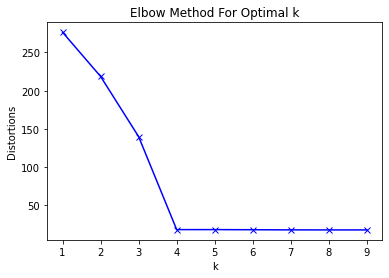

In [31]:
plt.plot(K, distortions, 'bx-')
plt.xlabel('k')
plt.ylabel('Distortions')
plt.title('Elbow Method For Optimal k')
plt.show()

**The optimal K seems to be 4 according to canberra method.**

**Let's also double check the silhouette-score.**

In [32]:
sil = []
kmax = 10
K_sil = range(2,kmax+1)

for i in K_sil:
  kmeans_sil = KMeans(n_clusters = i).fit(helsinki_grouped_clustering)
  labels_sil = kmeans_sil.labels_
  sil.append(silhouette_score(helsinki_grouped_clustering, labels_sil, metric = 'canberra'))


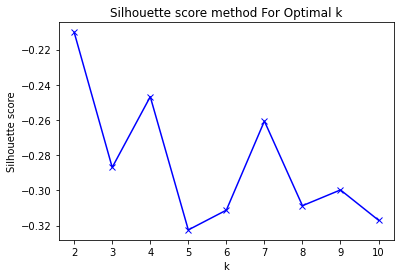

In [33]:
plt.plot(K_sil, sil, 'bx-')
plt.xlabel('k')
plt.ylabel('Silhouette score')
plt.title('Silhouette score method For Optimal k')
plt.show()

**According to the silhouette score, 2 or 4 is optimal so we will continue using 4.**

In [34]:
kmeans = KMeans(n_clusters=4, random_state=0).fit(helsinki_grouped_clustering)

kmeans.labels_

array([0, 0, 2, 1, 0, 0, 0, 2, 1, 0, 0, 1, 2, 0, 0, 3, 0, 0, 0, 0, 2, 0,
       0, 1, 2, 2, 3, 0, 2, 2, 2, 3, 2, 2, 2, 3, 2, 0, 2, 2, 3, 3, 3, 0,
       2, 0, 2, 0, 3, 3, 0, 0, 2, 2, 2, 2, 3, 0, 2, 0, 2, 2, 2, 3, 2, 0,
       0, 0, 0, 3, 0, 3, 0, 3, 0, 0, 2, 3])

**Let's add the cluster labels into our dataframe**

In [35]:
helsinki_complete = neighborhoods

# add clustering labels
helsinki_complete['Cluster Labels'] = kmeans.labels_

# merge toronto_grouped with toronto_data to add latitude/longitude for each neighborhood
helsinki_complete = helsinki_complete.join(neighborhoods_venues_sorted.set_index('Neighborhood'), on='Neighborhood')

helsinki_complete['Average price'] = helsinki_complete[['Average price']].astype('int64')

In [36]:
helsinki_complete.head(10) # check the last columns!

,Postcode,Neighborhood,Average price,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,00140,Kaivopuisto - Ullanlinna,8713,60.157935,24.952702,0,Coffee Shop,Grocery Store,Park,Ice Cream Shop,Scandinavian Restaurant,Recreation Center,Beer Garden,Thai Restaurant,Nightclub,Pharmacy
1,00150,Eira - Hernesaari,8367,60.158939,24.938014,0,Coffee Shop,Pizza Place,Park,Bakery,Scandinavian Restaurant,Café,Turkish Restaurant,French Restaurant,Modern European Restaurant,Beer Garden
2,00120,Punavuori,8160,60.163562,24.939202,2,Scandinavian Restaurant,Beer Bar,Bar,Hotel,Cocktail Bar,Pizza Place,Bakery,Coffee Shop,Sushi Restaurant,Park
3,00180,Kamppi - Ruoholahti,8023,60.163576,24.917557,1,Restaurant,Gym,Hotel,Beer Bar,Grocery Store,Liquor Store,Scandinavian Restaurant,Escape Room,Sauna / Steam Room,Park
4,00220,Jätkäsaari,7871,60.157433,24.917381,0,Bar,Electronics Store,Grocery Store,BBQ Joint,Food & Drink Shop,Canal,Pool,Supermarket,Falafel Restaurant,Boat or Ferry
5,00170,Kruununhaka,7841,60.171866,24.955321,0,Café,Boat or Ferry,Pizza Place,Bar,Scandinavian Restaurant,Grocery Store,Theater,History Museum,Coffee Shop,Indie Movie Theater
6,00130,Kaartinkaupunki,7825,60.165009,24.947547,0,Hotel,Scandinavian Restaurant,Bar,Park,Cocktail Bar,Pizza Place,Coffee Shop,Café,Beer Bar,Modern European Restaurant
7,00580,Verkkosaari,7609,60.189562,24.976701,2,Gym / Fitness Center,Supermarket,Event Space,Food Court,Italian Restaurant,Scandinavian Restaurant,Burger Joint,Bar,Café,Grocery Store
8,00100,Helsinki Keskusta - Etu-Töölö,7575,60.169989,24.933727,1,Scandinavian Restaurant,Wine Bar,Art Museum,Clothing Store,Food Court,Sushi Restaurant,Beer Bar,Beer Garden,Tea Room,Middle Eastern Restaurant
9,00260,Keski-Töölö,7384,60.180014,24.924237,0,Sushi Restaurant,Scandinavian Restaurant,Park,Hotel,French Restaurant,Coffee Shop,Italian Restaurant,Bakery,Plaza,Gym / Fitness Center


**Visualize the clusters on the map**

In [37]:
# Another folium map for visualizing clusters

# create map
helsinki_map_clusters = folium.Map(location=[latitude, longitude], zoom_start=11)
kclusters = 4

# set color scheme for the clusters
rainbow = ['red', 'darkgreen', 'blue', 'orange']

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(helsinki_complete['Latitude'], helsinki_complete['Longitude'], helsinki_complete['Neighborhood'], helsinki_complete['Cluster Labels']):
    label = folium.Popup(str(poi) + ' / ' + 'Cluster: ' + str(cluster), parse_html=True, min_width=100, max_width=300)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(helsinki_map_clusters)


       
helsinki_map_clusters

**The clusters does not seem to be affected by geographic location as much as expected (based on where certain sorts of venues may more likely be located). Lets check the most common venue per neighborhood.**

In [38]:
# 1st most popular venues per cluster
venue_total = helsinki_complete.copy()
venue_total = venue_total.drop(['Neighborhood','Average price', 'Latitude', 'Longitude'], axis=1)
venue_total = venue_total.groupby(['Cluster Labels','1st Most Common Venue']).size().reset_index(name='Count')
venue_total

,Cluster Labels,1st Most Common Venue,Count
0,0,Bar,4
1,0,Baseball Field,1
2,0,Boat or Ferry,1
3,0,Bus Stop,7
4,0,Café,3
5,0,Coffee Shop,4
6,0,Grocery Store,1
7,0,Gym,1
8,0,Gym / Fitness Center,1
9,0,Hostel,1


In [39]:
cluster_comp = venue_total.pivot(index='Cluster Labels', columns='1st Most Common Venue', values='Count')
cluster_comp = cluster_comp.fillna(0).astype(int).reset_index(drop=True)
cluster_comp

1st Most Common Venue,Bar,Baseball Field,Boat or Ferry,Bus Stop,Café,Coffee Shop,Dog Run,Forest,French Restaurant,Garden,Grocery Store,Gym,Gym / Fitness Center,Hostel,Hotel,Italian Restaurant,Music Venue,Pizza Place,Playground,Recreation Center,Restaurant,Scandinavian Restaurant,Soccer Field,Sushi Restaurant,Tram Station
0,4,1,1,7,3,4,0,0,0,0,1,1,1,1,1,0,0,1,1,0,0,0,2,1,2
1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,1,0,0,0
2,1,0,0,12,0,0,1,1,1,1,1,0,3,0,0,0,1,2,1,1,0,1,0,0,0
3,0,0,0,9,1,0,0,0,0,0,1,0,0,0,0,0,0,2,0,0,0,0,1,0,1


**Lets plot it as well.**

Text(0.5, 0, 'Clusters')

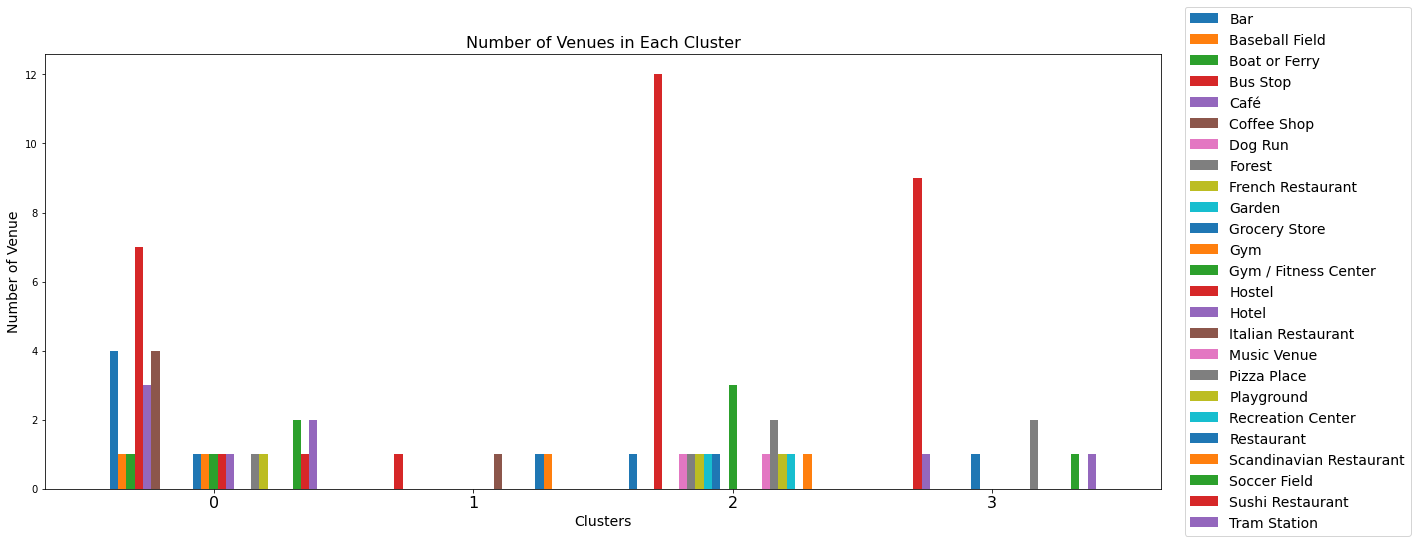

In [40]:
bar_c = cluster_comp.iloc[0:].plot(kind='bar',figsize=(20,8),width = 0.8)

plt.legend(labels=cluster_comp.columns,fontsize= 14, loc="center right", bbox_to_anchor=(1.23, 0.5), ncol=1)
plt.title("Number of Venues in Each Cluster",fontsize= 16)
plt.xticks(fontsize=16)
plt.xticks(rotation=0)
plt.ylabel('Number of Venue', fontsize=14)
plt.xlabel('Clusters', fontsize=14)

**Since the bar chart is somewhat messy due to the amount of different venues, I will create a new barchart where some venues that are very similar are merged.**

In [41]:
cat_cluster_comp = cluster_comp.copy()
cat_cluster_comp['Cafés'] = cat_cluster_comp[['Café', 'Coffee Shop']].sum(axis = 1, skipna = True)
cat_cluster_comp['Bars and music venues'] = cat_cluster_comp[['Bar', 'Music Venue']].sum(axis = 1, skipna = True)
cat_cluster_comp['Restaurants'] = cat_cluster_comp[['French Restaurant', 'Italian Restaurant', 'Sushi Restaurant', 'Scandinavian Restaurant', 'Pizza Place', 'Restaurant']].sum(axis = 1, skipna = True)
cat_cluster_comp['Sports facilities'] = cat_cluster_comp[['Baseball Field', 'Gym / Fitness Center', 'Gym', 'Soccer Field', 'Recreation Center']].sum(axis = 1, skipna = True)
cat_cluster_comp['Transport stations'] = cat_cluster_comp[['Boat or Ferry', 'Bus Stop', 'Tram Station']].sum(axis = 1, skipna = True)
cat_cluster_comp['Stores'] = cat_cluster_comp[['Grocery Store']].sum(axis = 1, skipna = True)
cat_cluster_comp['Outdoors areas'] = cat_cluster_comp[['Playground', 'Forest', 'Garden', 'Dog Run']].sum(axis = 1, skipna = True)
cat_cluster_comp['Hotel and hostels'] = cat_cluster_comp[['Hostel', 'Hotel']].sum(axis = 1, skipna = True)

In [42]:

cat_cluster = cat_cluster_comp[['Cafés','Bars and music venues','Restaurants', 'Sports facilities', 'Transport stations', 'Stores', 'Outdoors areas', 'Hotel and hostels']]

Text(0.5, 0, 'Clusters')

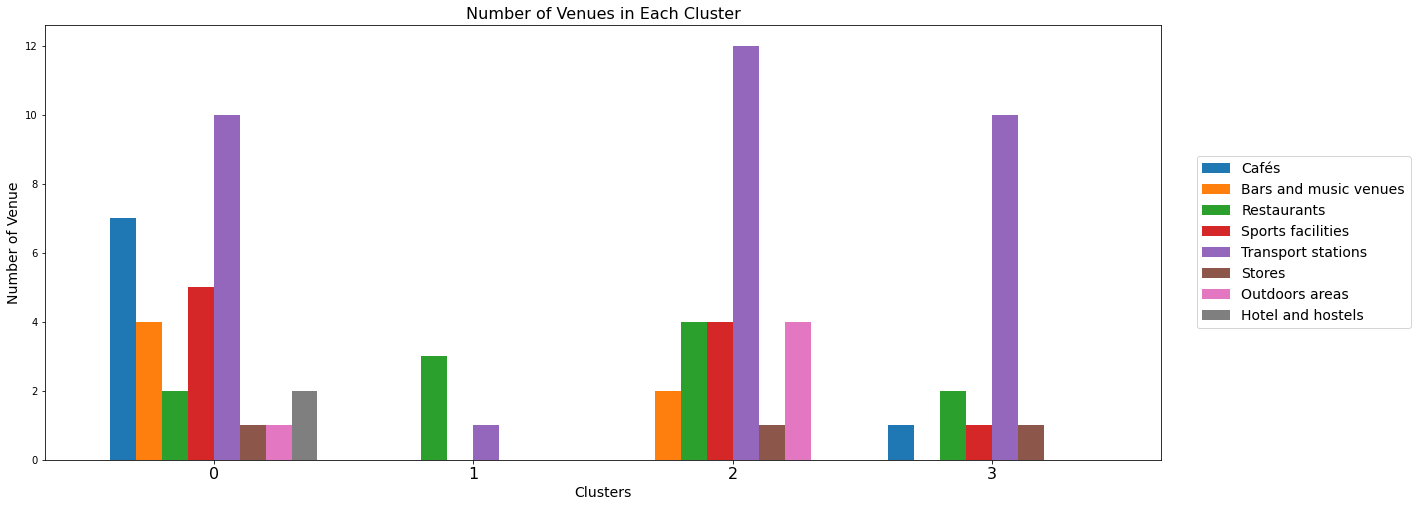

In [43]:
bar_dfd = cat_cluster.plot(kind='bar',figsize=(20,8),width = 0.8)

plt.legend(labels=cat_cluster.columns,fontsize= 14, loc="center right", bbox_to_anchor=(1.23, 0.5), ncol=1)
plt.title("Number of Venues in Each Cluster",fontsize= 16)
plt.xticks(fontsize=16)
plt.xticks(rotation=0)
plt.ylabel('Number of Venue', fontsize=14)
plt.xlabel('Clusters', fontsize=14)

# 6 Price average per cluster

We do see some differences, but lets also start comparing the clusters with the average price per square meter data we retrieved earlier

In [44]:
helsinki_complete


price_average = helsinki_complete.copy()
price_average = price_average[['Average price', 'Cluster Labels']]
price_average['Average price'] = price_average['Average price'].astype(str).astype(int)
price_average = price_average.groupby('Cluster Labels').mean()
price_average

,Average price
Cluster Labels,
0,5196.43750
1,7138.50000
2,4640.62963
3,3998.80000


**While cluster 0 and 1 definitly have a higher average price, many of the neighborhoods included in these clusters are located closer to the city center.**

**Let's see what happens if we plot the average price geographically.**

**Getting the geometry information using Helsinkis WFS**

In [45]:
hsy_url = 'https://kartta.hsy.fi/geoserver/wfs'
wfs_import = WebFeatureService(url= hsy_url, version='1.1.0')

**Read in the data and checking schematics.**

In [46]:
response = wfs_import.getfeature(typename='taustakartat_ja_aluejaot:pks_postinumeroalueet_2020')

schematics = wfs_import.get_schema('taustakartat_ja_aluejaot:pks_postinumeroalueet_2020')
# Checkig the schematics of the import
schematics

{'properties': {'posno': 'string',
  'toimip': 'string',
  'toimip_ru': 'string',
  'nimi': 'string',
  'nimi_ru': 'string',
  'kunta': 'string',
  'kunta_nro': 'string'},
 'required': [],
 'geometry': '3D MultiPolygon',
 'geometry_column': 'geom'}

**Reading and saving kml file.**

In [50]:
out = open('data_kml_pk_postinro.kml', 'wb')
result = response.read()
if isinstance(result, bytes):
    out.write(result)
else :
    out.write(bytes(result, 'UTF-8'))
    
out.close()



**Since we want file as a geojson/json format, we use gdal library to convert and save it**

In [51]:
srcDS = gdal.OpenEx('data_kml_pk_postinro.kml')
geods = gdal.VectorTranslate('output.json', srcDS, format='GeoJSON')

**Added ']}' manually to the end of the file since it was missing. Saving the file afterwards into dataframe.**

In [52]:
postal_areas = gpd.read_file('output.json')
postal_areas.head()

,gml_id,posno,toimip,toimip_ru,nimi,nimi_ru,kunta,kunta_nro,geometry
0,pks_postinumeroalueet_2020.1,00100,HELSINKI,HELSINGFORS,Helsinki Keskusta - Etu-Töölö,Helsingfors centrum - Främre Tölö,Helsinki,091,"MULTIPOLYGON (((25495415.010 6673755.420, 2549..."
1,pks_postinumeroalueet_2020.2,00120,HELSINKI,HELSINGFORS,Punavuori,Rödbergen,Helsinki,091,"MULTIPOLYGON (((25496720.730 6672703.770, 2549..."
2,pks_postinumeroalueet_2020.3,00130,HELSINKI,HELSINGFORS,Kaartinkaupunki,Gardesstaden,Helsinki,091,"MULTIPOLYGON (((25496776.230 6672752.055, 2549..."
3,pks_postinumeroalueet_2020.4,00140,HELSINKI,HELSINGFORS,Kaivopuisto - Ullanlinna,Brunnsparken - Ulrikasborg,Helsinki,091,"MULTIPOLYGON (((25497132.180 6672015.420, 2549..."
4,pks_postinumeroalueet_2020.5,00150,HELSINKI,HELSINGFORS,Eira - Hernesaari,Eira - Ärtholmen,Helsinki,091,"MULTIPOLYGON (((25496970.120 6671136.315, 2549..."


**Checking shape.**

In [53]:
postal_areas.shape

(172, 9)

**The original coordinate system does not work for the folium map later on, so changing it to a normal format.**

In [54]:
postal_areas.crs = CRS.from_epsg(3879)

postal_areas_new = postal_areas.to_crs(epsg=4326)
postal_areas_new.head()

,gml_id,posno,toimip,toimip_ru,nimi,nimi_ru,kunta,kunta_nro,geometry
0,pks_postinumeroalueet_2020.1,00100,HELSINKI,HELSINGFORS,Helsinki Keskusta - Etu-Töölö,Helsingfors centrum - Främre Tölö,Helsinki,091,"MULTIPOLYGON (((24.91739 60.17664, 24.91766 60..."
1,pks_postinumeroalueet_2020.2,00120,HELSINKI,HELSINGFORS,Punavuori,Rödbergen,Helsinki,091,"MULTIPOLYGON (((24.94093 60.16721, 24.94107 60..."
2,pks_postinumeroalueet_2020.3,00130,HELSINKI,HELSINGFORS,Kaartinkaupunki,Gardesstaden,Helsinki,091,"MULTIPOLYGON (((24.94193 60.16764, 24.95107 60..."
3,pks_postinumeroalueet_2020.4,00140,HELSINKI,HELSINGFORS,Kaivopuisto - Ullanlinna,Brunnsparken - Ulrikasborg,Helsinki,091,"MULTIPOLYGON (((24.94835 60.16103, 24.94846 60..."
4,pks_postinumeroalueet_2020.5,00150,HELSINKI,HELSINGFORS,Eira - Hernesaari,Eira - Ärtholmen,Helsinki,091,"MULTIPOLYGON (((24.94545 60.15314, 24.94237 60..."


**Since datafram contains data of other cities in the capital area as well as some columns that are not needed we will clean the data**

In [55]:
cleaned_dataframe = postal_areas_new.copy()
cleaned_dataframe = cleaned_dataframe.loc[cleaned_dataframe['toimip'] == 'HELSINKI']
cleaned_dataframe.drop(columns=['gml_id', 'toimip', 'toimip_ru', 'nimi', 'nimi_ru', 'kunta', 'kunta_nro'], axis = 1, inplace = True)
cleaned_dataframe.reset_index(drop=True, inplace=True)
cleaned_dataframe.head()

,posno,geometry
0,00100,"MULTIPOLYGON (((24.91739 60.17664, 24.91766 60..."
1,00120,"MULTIPOLYGON (((24.94093 60.16721, 24.94107 60..."
2,00130,"MULTIPOLYGON (((24.94193 60.16764, 24.95107 60..."
3,00140,"MULTIPOLYGON (((24.94835 60.16103, 24.94846 60..."
4,00150,"MULTIPOLYGON (((24.94545 60.15314, 24.94237 60..."


**Lets merge data with data from our previous dataframe so that we have everything we need in one df.**

**Also renaming Postcode column for easier merger.**

In [56]:
price_data = helsinki_complete[['Postcode', 'Neighborhood', 'Average price']]
price_data.rename(columns= {'Postcode': 'posno'}, inplace=True)
price_data.head()

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\frame.py:4296: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().rename(


,posno,Neighborhood,Average price
0,00140,Kaivopuisto - Ullanlinna,8713
1,00150,Eira - Hernesaari,8367
2,00120,Punavuori,8160
3,00180,Kamppi - Ruoholahti,8023
4,00220,Jätkäsaari,7871


In [57]:
merged_df = cleaned_dataframe.merge(price_data, left_on='posno', right_on='posno')
merged_df.head()


,posno,geometry,Neighborhood,Average price
0,00100,"MULTIPOLYGON (((24.91739 60.17664, 24.91766 60...",Helsinki Keskusta - Etu-Töölö,7575
1,00120,"MULTIPOLYGON (((24.94093 60.16721, 24.94107 60...",Punavuori,8160
2,00130,"MULTIPOLYGON (((24.94193 60.16764, 24.95107 60...",Kaartinkaupunki,7825
3,00140,"MULTIPOLYGON (((24.94835 60.16103, 24.94846 60...",Kaivopuisto - Ullanlinna,8713
4,00150,"MULTIPOLYGON (((24.94545 60.15314, 24.94237 60...",Eira - Hernesaari,8367


**Checking if we have any null values**

In [58]:
merged_df.isnull().values.any()

False

**Great! Lets map it**

In [59]:
helsinki_map_choro = folium.Map(location=[latitude, longitude], zoom_start=11)

folium.Choropleth(
    geo_data=merged_df,
    data=merged_df,
    columns=['Neighborhood', 'Average price'],
    key_on='feature.properties.Neighborhood',
    fill_color='YlOrRd', 
    fill_opacity=0.7, 
    line_opacity=0.2,
    legend_name='Average price/m2',
    nan_fill_color = 'white'
).add_to(helsinki_map_choro)

# display map
helsinki_map_choro

**As we can see, it is clear that it is more expensive the closer to the city closer the neighborhood is located. If we also plot the clusters we can get some idea over how similar neighborhoods may be different in price depending on their geographical location.**

In [60]:
rainbow = ['red', 'darkgreen', 'blue', 'orange']

for lat, lon, poi, cluster, price in zip(helsinki_complete['Latitude'], helsinki_complete['Longitude'], helsinki_complete['Neighborhood'], helsinki_complete['Cluster Labels'], helsinki_complete['Average price']):
    label = folium.Popup(str(poi) + ' / ' + ' Cluster: ' + str(cluster) + ' / ' + 'Price: ' + str(price), parse_html=True, min_width=200, max_width=300)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.5).add_to(helsinki_map_choro)

helsinki_map_choro